In [ ]:
#Import all necessary files
import numpy as np
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wsp_for_one_feature.csv')
print(df.head()) #7 columns, including the Date.


Plot Loading... 


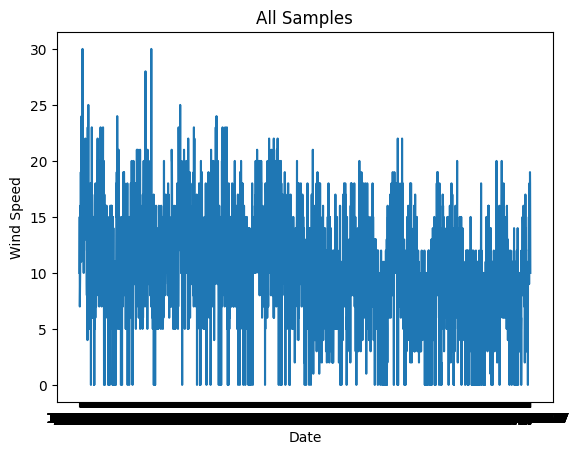

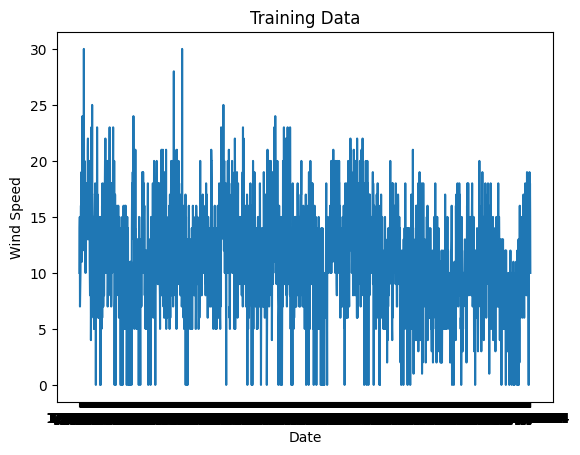

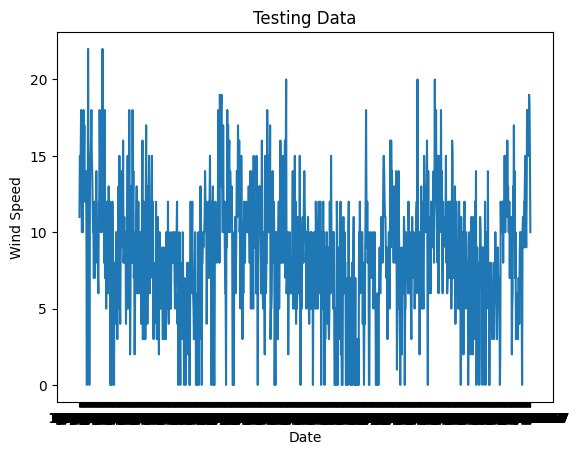

In [ ]:
# Plotting the All Wind speed data
print("Plot Loading... ")
plt.plot(df["date"], df["wsp"])
plt.title("All Samples")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()

#Plot Training Data
train_date= df.loc[0:2556, 'date']
train_wsp= df.loc[0:2556,'wsp']
train_date= pd.DataFrame(train_date)
train_wsp= pd.DataFrame(train_wsp)
train_data  = train_date.join(train_wsp,how='outer')

plt.plot(train_data["date"], train_data["wsp"])
plt.title("Training Data")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()

#Plot Testing Data
test_date= df.loc[2557:3652, 'date']
test_wsp= df.loc[2557:3652,'wsp']
test_date= pd.DataFrame(test_date)
test_wsp= pd.DataFrame(test_wsp)
test_data  = test_date.join(test_wsp,how='outer')

plt.plot(test_data["date"], test_data["wsp"])
plt.title("Testing Data")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()

In [ ]:
#Variables for training
cols = list(df)[1:2]
#Date and volume columns are not used in training.
print(cols) #['wsp']

df_for_training = df[cols].astype(float)

raw = df['wsp'].tolist()


['wsp']


In [ ]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X = list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x = sequence[i:end_ix]
		X.append(seq_x)

	return array(X)


In [ ]:
# define input sequence
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 6
# split into samples
X= split_sequence(raw, n_steps)

In [ ]:
#Pre-processed dataset
df = pd.DataFrame(X)
df_for_training = df.astype(float)
print(df_for_training.head())

      0     1     2     3     4     5
0  10.0  14.0  15.0   7.0   8.0   9.0
1  14.0  15.0   7.0   8.0   9.0  10.0
2  15.0   7.0   8.0   9.0  10.0  13.0
3   7.0   8.0   9.0  10.0  13.0  16.0
4   8.0   9.0  10.0  13.0  16.0  16.0


In [ ]:
#Standardize the datasets
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
#Empty lists to be populated using formatted training data
X = []
Y = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 1  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In this example, df_for_training_scaled has a shape (3653, 1)
#3653 refers to the number of data points and 1 refers to the columns (single-variable).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    X.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    Y.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

X, Y = np.array(X), np.array(Y)
print('X shape == {}.'.format(X.shape))
print('Y shape == {}.'.format(Y.shape))

X shape == (3646, 1, 6).
Y shape == (3646, 1).


In [ ]:
#Splitting data to testing and training sets
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test= train_test_split(X, Y, test_size= 0.3, random_state= 10)


In [ ]:
#Stacked LSTM Architecture
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
#model.add(LSTM(100, activation='tanh', return_sequences=False))
# model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1]))

# model.compile(optimizer='adam', loss='mse')
model.compile(
    optimizer="adam",
    loss="mse",
)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40)                5760      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 5,801
Trainable params: 5,801
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
48/48 [==============================] - 3s 33ms/step - loss: 0.7012 - val_loss: 0.5119
Epoch 2/20
48/48 [==============================] - 0s 4ms/step - loss: 0.3657 - val_loss: 0.2594
Epoch 3/20
48/48 [==============================] - 0s 5ms/step - loss: 0.1825 - val_loss: 0.0987
Epoch 4/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0687 - val_loss: 0.0244
Epoch 5/20
48/48 [==============================] - 1s 22ms/step - loss: 0.0318 - val_loss: 0.0087
Epoch 6/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0239 - val_loss: 0.0064
Epoch 7/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0056
Epoch 8/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0212 - val_loss: 0.0053
Epoch 9/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0201 - val_loss: 0.0045
Epoch 10/20
48/48 [==============================] - 1s 23ms/step - loss: 0.0210 - val_loss: 0.0043
Epoch 11/20
48/

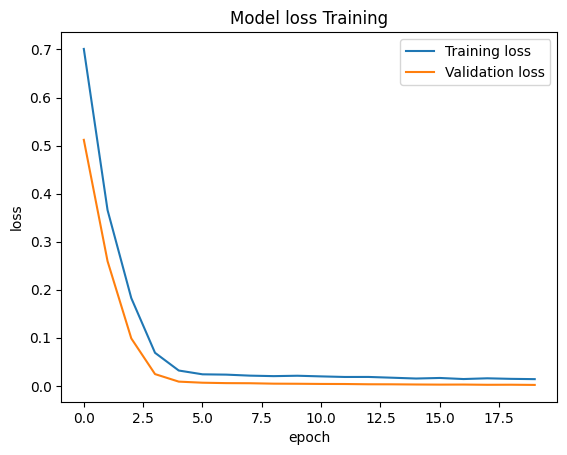

In [ ]:
# fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=48, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Model loss Training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [ ]:
#Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)


Evaluate on test data
69/69 [==============================] - 0s 2ms/step - loss: 0.0022
test loss, test acc: 0.00221875193528831


In [ ]:
#Make prediction
prediction = model.predict(X_test)


35/35 [==============================] - 1s 16ms/step


In [ ]:
#Unstandardize the y_pred and y_test
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred = scaler.inverse_transform(prediction_copies)[:,0].astype(float)
y_test_copies = np.repeat(y_test, df_for_training.shape[1], axis=-1)
y_true = scaler.inverse_transform(y_test_copies)[:,0]

In [ ]:
#Performance Metrics
mse = sklearn.metrics.mean_squared_error(y_pred,y_true)
import math
rmse = math.sqrt(mse)
mae= sklearn.metrics.mean_absolute_error(y_pred,y_true)
r2= sklearn.metrics.r2_score(y_pred,y_true)#Coefficient of Determination (R2)
me= sklearn.metrics.max_error(y_true, y_pred)
from sklearn.metrics import mean_absolute_percentage_error
mape= mean_absolute_percentage_error(y_pred, y_true)
r = np.corrcoef(y_pred, y_true)


In [ ]:
#Print all Performance metrics
print(f'me= {me}')
print(f'mse= {mse}')
print(f'mae= {mae}')
print(f'rmse= {rmse}')
print(f'r2= {r2}')
print(f'mape= {mape}')


me= 1.1019147634506226
mse= 0.04714478013828412
mae= 0.15839910301698246
rmse= 0.21712848762491788
r2= 0.997776390941019
mape= 0.05182679134168133


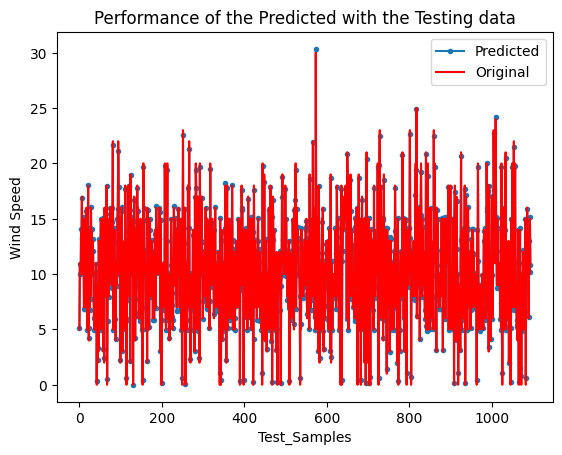

In [ ]:
#Plotting the Predicted and Testing data
plt.title('Performance of the Predicted with the Testing data')
plt.plot(y_pred.flatten(),marker= '.', label='Predicted')
plt.plot(y_true.flatten(),'r', label='Original')
plt.xlabel("Test_Samples")
plt.ylabel("Wind Speed")
plt.legend()